In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
pip install torch torchvision albumentations opencv-python matplotlib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 31.6 MB/s eta 0:00:00
  Attempting uninstall: sympy
    Found existing installation: sympy 1.12
    Uninstalling sympy-1.12:
      Successfully uninstalled sympy-1.12


In [27]:
!pip uninstall -y sympy
!pip install sympy==1.12


Found existing installation: sympy 1.12
Uninstalling sympy-1.12:
  Successfully uninstalled sympy-1.12
  Using cached sympy-1.12-py3-none-any.whl.metadata (12 kB)
Using cached sympy-1.12-py3-none-any.whl (5.7 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires sympy==1.13.1; python_version >= "3.9", but you have sympy 1.12 which is incompatible.


In [4]:
import os
import cv2
import random
import numpy as np


from torch import nn, optim
from torch.utils.data import Dataset, DataLoader


from sklearn.model_selection import train_test_split
from tqdm import tqdm
from PIL import Image

import albumentations as A
from albumentations.pytorch import ToTensorV2


In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.pool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.pool_conv(x)

class Up(nn.Module):
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_channels // 2, in_channels // 2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)

        # Padding in case the input dimensions are odd
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 512)
        self.up1 = Up(1024, 256, bilinear)
        self.up2 = Up(512, 128, bilinear)
        self.up3 = Up(256, 64, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits


In [6]:
TRAIN_IMG_DIR = "/content/drive/MyDrive/segmentation-herlev/train/images/img"
TRAIN_MASK_DIR = "/content/drive/MyDrive/segmentation-herlev/train/gt/img"
VAL_IMG_DIR = "/content/drive/MyDrive/segmentation-herlev/val/images"
VAL_MASK_DIR = "/content/drive/MyDrive/segmentation-herlev/val/gt"


print("Train images:", len(os.listdir(TRAIN_IMG_DIR)))
print("Train masks:", len(os.listdir(TRAIN_MASK_DIR)))

Train images: 550
Train masks: 550


In [7]:
 #def get_training_transforms():
    #return A.Compose([
        #A.Resize(256, 256),
       # A.Rotate(limit=35, p=0.5),
        #A.HorizontalFlip(p=0.5),
       # A.VerticalFlip(p=0.5),
       # A.ColorJitter(p=0.5),
       # A.Normalize(mean=[0.485, 0.456, 0.406],
                   # std=[0.229, 0.224, 0.225]),
        #ToTensorV2(),
   # ])

#def get_validation_transforms():
    #return A.Compose([
      #  A.Resize(256, 256),
      #  A.Normalize(mean=[0.485, 0.456, 0.406],
               #     std=[0.229, 0.224, 0.225]),
      # ToTensorV2(),
   # ])




from albumentations.pytorch import ToTensorV2
import albumentations as A

def get_training_transforms():
    return A.Compose([
        A.Resize(256, 256),
       ToTensorV2()
    ])

def get_validation_transforms():
    return A.Compose([
        A.Resize(256, 256),
        ToTensorV2()
    ])

In [8]:
class HerlevDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform

        # Only include valid image files (avoid hidden files like .DS_Store)
        self.images = sorted([f for f in os.listdir(image_dir) if f.endswith(('.png', '.bmp', '.BMP'))])
        self.masks = sorted([f for f in os.listdir(mask_dir) if f.endswith(('.png', '.bmp', '.BMP'))])

        # Optional: check that number of images == masks
        assert len(self.images) == len(self.masks), "Mismatch between image and mask counts"

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.masks[idx])

        # --- Debug: check existence of files ---
        if not os.path.exists(img_path):
            raise FileNotFoundError(f" Image not found: {img_path}")
        if not os.path.exists(mask_path):
            raise FileNotFoundError(f" Mask not found: {mask_path}")

        # --- Load image and mask ---
        image = cv2.imread(img_path)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        # --- Debug: check if images are loaded properly ---
        if image is None:
            raise ValueError(f" Failed to load image: {img_path}")
        if mask is None:
            raise ValueError(f" Failed to load mask: {mask_path}")

        # Convert BGR to RGB
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # --- Convert image to float and scale to [0, 1] ---
        image = image.astype(np.float32) / 255.0

        # --- Convert mask pixel values to class indices ---
        unique_values = sorted(np.unique(mask))
        value_to_index = {v: i for i, v in enumerate(unique_values)}
        mask = np.vectorize(value_to_index.get)(mask)

        # --- Apply transforms ---
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        return image, mask.long()

In [9]:
print("TRAIN_IMG_DIR:", TRAIN_IMG_DIR)
print("TRAIN_MASK_DIR:", TRAIN_MASK_DIR)
print("VAL_IMG_DIR:", VAL_IMG_DIR)
print("VAL_MASK_DIR:", VAL_MASK_DIR)

print("\n File counts:")
print("Train Images:", len([f for f in os.listdir(TRAIN_IMG_DIR) if f.endswith('.BMP')]))
print("Train Masks :", len([f for f in os.listdir(TRAIN_MASK_DIR) if f.endswith('.bmp')]))
print("Val Images  :", len([f for f in os.listdir(VAL_IMG_DIR) if f.endswith('.BMP')]))
print("Val Masks   :", len([f for f in os.listdir(VAL_MASK_DIR) if f.endswith('.bmp')]))


TRAIN_IMG_DIR: /content/drive/MyDrive/segmentation-herlev/train/images/img
TRAIN_MASK_DIR: /content/drive/MyDrive/segmentation-herlev/train/gt/img
VAL_IMG_DIR: /content/drive/MyDrive/segmentation-herlev/val/images
VAL_MASK_DIR: /content/drive/MyDrive/segmentation-herlev/val/gt

 File counts:
Train Images: 550
Train Masks : 550
Val Images  : 185
Val Masks   : 185


In [10]:
train_dataset = HerlevDataset(TRAIN_IMG_DIR, TRAIN_MASK_DIR, transform=get_training_transforms())
val_dataset   = HerlevDataset(VAL_IMG_DIR, VAL_MASK_DIR, transform=get_validation_transforms())

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=2)

In [11]:
def compute_iou(preds, labels, n_classes=5):
    ious = []
    preds = preds.view(-1)
    labels = labels.view(-1)

    for cls in range(n_classes):
        pred_inds = preds == cls
        label_inds = labels == cls
        intersection = (pred_inds & label_inds).sum().item()
        union = pred_inds.sum().item() + label_inds.sum().item() - intersection
        if union == 0:
            ious.append(float('nan'))
        else:
            ious.append(intersection / union)
    return np.nanmean(ious)


In [12]:
def train_epoch(model, loader, optimizer, criterion, device):
    model.train()
    epoch_loss = 0
    ious = []

    for images, masks in tqdm(loader):
        images, masks = images.to(device), masks.to(device)

        preds = model(images)
        loss = criterion(preds, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        ious.append(compute_iou(preds.argmax(dim=1), masks))

    return epoch_loss / len(loader), np.mean(ious)


def validate_epoch(model, loader, criterion, device):
    model.eval()
    val_loss = 0
    ious = []

    with torch.no_grad():
        for images, masks in loader:
            images, masks = images.to(device), masks.to(device)

            preds = model(images)
            loss = criterion(preds, masks)

            val_loss += loss.item()
            ious.append(compute_iou(preds.argmax(dim=1), masks))

    return val_loss / len(loader), np.mean(ious)


In [13]:
def train_model(model, train_loader, val_loader, num_epochs, device, learning_rate=1e-4):
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5)

    best_val_iou = 0

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")

        train_loss, train_iou = train_epoch(model, train_loader, optimizer, criterion, device)
        val_loss, val_iou = validate_epoch(model, val_loader, criterion, device)

        scheduler.step(val_loss)

        print(f"Train Loss: {train_loss:.4f}, IoU: {train_iou:.4f}")
        print(f"Val   Loss: {val_loss:.4f}, IoU: {val_iou:.4f}")

        if val_iou > best_val_iou:
            best_val_iou = val_iou
            torch.save(model.state_dict(), "/content/drive/MyDrive/segmentation-herlev/best_unet_herlev.pth")
            print(f"✅ New best model saved! IoU: {best_val_iou:.4f}")

        print("-" * 50)



In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet(n_channels=3, n_classes=5).to(device)

train_model(model, train_loader, val_loader, num_epochs=100, device=device)

torch.save(model.state_dict(), "/content/drive/MyDrive/segmentation-herlev/best_unet_herlev.pth")



Epoch 1/100


100%|██████████| 138/138 [02:55<00:00,  1.27s/it]


Train Loss: 1.3197, IoU: 0.2149
Val   Loss: 1.3917, IoU: 0.2370
✅ New best model saved! IoU: 0.2370
--------------------------------------------------
Epoch 2/100


100%|██████████| 138/138 [00:25<00:00,  5.39it/s]


Train Loss: 1.1921, IoU: 0.2334
Val   Loss: 1.2154, IoU: 0.2523
✅ New best model saved! IoU: 0.2523
--------------------------------------------------
Epoch 3/100


100%|██████████| 138/138 [00:25<00:00,  5.36it/s]


Train Loss: 1.1478, IoU: 0.2455
Val   Loss: 1.2428, IoU: 0.2558
✅ New best model saved! IoU: 0.2558
--------------------------------------------------
Epoch 4/100


100%|██████████| 138/138 [00:25<00:00,  5.50it/s]


Train Loss: 1.1262, IoU: 0.2509
Val   Loss: 1.1582, IoU: 0.2654
✅ New best model saved! IoU: 0.2654
--------------------------------------------------
Epoch 5/100


100%|██████████| 138/138 [00:25<00:00,  5.50it/s]


Train Loss: 1.1134, IoU: 0.2498
Val   Loss: 1.1049, IoU: 0.2701
✅ New best model saved! IoU: 0.2701
--------------------------------------------------
Epoch 6/100


100%|██████████| 138/138 [00:25<00:00,  5.51it/s]


Train Loss: 1.0917, IoU: 0.2595
Val   Loss: 1.1075, IoU: 0.2694
--------------------------------------------------
Epoch 7/100


100%|██████████| 138/138 [00:24<00:00,  5.69it/s]


Train Loss: 1.0784, IoU: 0.2626
Val   Loss: 1.1151, IoU: 0.2507
--------------------------------------------------
Epoch 8/100


100%|██████████| 138/138 [00:24<00:00,  5.67it/s]


Train Loss: 1.0843, IoU: 0.2557
Val   Loss: 1.0993, IoU: 0.2764
✅ New best model saved! IoU: 0.2764
--------------------------------------------------
Epoch 9/100


100%|██████████| 138/138 [00:25<00:00,  5.50it/s]


Train Loss: 1.0603, IoU: 0.2727
Val   Loss: 1.0766, IoU: 0.2789
✅ New best model saved! IoU: 0.2789
--------------------------------------------------
Epoch 10/100


100%|██████████| 138/138 [00:25<00:00,  5.46it/s]


Train Loss: 1.0597, IoU: 0.2633
Val   Loss: 1.0527, IoU: 0.2785
--------------------------------------------------
Epoch 11/100


100%|██████████| 138/138 [00:24<00:00,  5.67it/s]


Train Loss: 1.0450, IoU: 0.2676
Val   Loss: 1.0525, IoU: 0.2801
✅ New best model saved! IoU: 0.2801
--------------------------------------------------
Epoch 12/100


100%|██████████| 138/138 [00:25<00:00,  5.48it/s]


Train Loss: 1.0414, IoU: 0.2714
Val   Loss: 1.0731, IoU: 0.2829
✅ New best model saved! IoU: 0.2829
--------------------------------------------------
Epoch 13/100


100%|██████████| 138/138 [00:25<00:00,  5.49it/s]


Train Loss: 1.0292, IoU: 0.2734
Val   Loss: 1.1015, IoU: 0.2839
✅ New best model saved! IoU: 0.2839
--------------------------------------------------
Epoch 14/100


100%|██████████| 138/138 [00:25<00:00,  5.50it/s]


Train Loss: 1.0313, IoU: 0.2725
Val   Loss: 1.0832, IoU: 0.2742
--------------------------------------------------
Epoch 15/100


100%|██████████| 138/138 [00:24<00:00,  5.68it/s]


Train Loss: 1.0239, IoU: 0.2766
Val   Loss: 1.0402, IoU: 0.2904
✅ New best model saved! IoU: 0.2904
--------------------------------------------------
Epoch 16/100


100%|██████████| 138/138 [00:25<00:00,  5.49it/s]


Train Loss: 1.0087, IoU: 0.2789
Val   Loss: 1.0201, IoU: 0.2903
--------------------------------------------------
Epoch 17/100


100%|██████████| 138/138 [00:24<00:00,  5.66it/s]


Train Loss: 1.0007, IoU: 0.2904
Val   Loss: 1.0935, IoU: 0.2796
--------------------------------------------------
Epoch 18/100


100%|██████████| 138/138 [00:24<00:00,  5.65it/s]


Train Loss: 0.9968, IoU: 0.2860
Val   Loss: 1.0280, IoU: 0.2912
✅ New best model saved! IoU: 0.2912
--------------------------------------------------
Epoch 19/100


100%|██████████| 138/138 [00:25<00:00,  5.47it/s]


Train Loss: 0.9890, IoU: 0.2941
Val   Loss: 1.0025, IoU: 0.2921
✅ New best model saved! IoU: 0.2921
--------------------------------------------------
Epoch 20/100


100%|██████████| 138/138 [00:25<00:00,  5.43it/s]


Train Loss: 0.9799, IoU: 0.2963
Val   Loss: 1.0240, IoU: 0.2943
✅ New best model saved! IoU: 0.2943
--------------------------------------------------
Epoch 21/100


100%|██████████| 138/138 [00:25<00:00,  5.38it/s]


Train Loss: 0.9756, IoU: 0.2972
Val   Loss: 0.9987, IoU: 0.3069
✅ New best model saved! IoU: 0.3069
--------------------------------------------------
Epoch 22/100


100%|██████████| 138/138 [00:24<00:00,  5.54it/s]


Train Loss: 0.9658, IoU: 0.3039
Val   Loss: 1.0115, IoU: 0.3070
✅ New best model saved! IoU: 0.3070
--------------------------------------------------
Epoch 23/100


100%|██████████| 138/138 [00:25<00:00,  5.49it/s]


Train Loss: 0.9671, IoU: 0.3061
Val   Loss: 1.0007, IoU: 0.2750
--------------------------------------------------
Epoch 24/100


100%|██████████| 138/138 [00:24<00:00,  5.66it/s]


Train Loss: 0.9594, IoU: 0.3072
Val   Loss: 0.9766, IoU: 0.3066
--------------------------------------------------
Epoch 25/100


100%|██████████| 138/138 [00:24<00:00,  5.69it/s]


Train Loss: 0.9497, IoU: 0.3098
Val   Loss: 0.9832, IoU: 0.3080
✅ New best model saved! IoU: 0.3080
--------------------------------------------------
Epoch 26/100


100%|██████████| 138/138 [00:25<00:00,  5.52it/s]


Train Loss: 0.9456, IoU: 0.3108
Val   Loss: 1.0048, IoU: 0.3028
--------------------------------------------------
Epoch 27/100


100%|██████████| 138/138 [00:24<00:00,  5.68it/s]


Train Loss: 0.9370, IoU: 0.3152
Val   Loss: 1.0112, IoU: 0.3043
--------------------------------------------------
Epoch 28/100


100%|██████████| 138/138 [00:24<00:00,  5.66it/s]


Train Loss: 0.9291, IoU: 0.3224
Val   Loss: 1.0159, IoU: 0.3025
--------------------------------------------------
Epoch 29/100


100%|██████████| 138/138 [00:24<00:00,  5.65it/s]


Train Loss: 0.9277, IoU: 0.3164
Val   Loss: 0.9905, IoU: 0.3053
--------------------------------------------------
Epoch 30/100


100%|██████████| 138/138 [00:24<00:00,  5.65it/s]


Train Loss: 0.9190, IoU: 0.3215
Val   Loss: 0.9958, IoU: 0.3073
--------------------------------------------------
Epoch 31/100


100%|██████████| 138/138 [00:24<00:00,  5.65it/s]


Train Loss: 0.8819, IoU: 0.3449
Val   Loss: 0.9621, IoU: 0.3138
✅ New best model saved! IoU: 0.3138
--------------------------------------------------
Epoch 32/100


100%|██████████| 138/138 [00:25<00:00,  5.47it/s]


Train Loss: 0.8612, IoU: 0.3537
Val   Loss: 0.9579, IoU: 0.3096
--------------------------------------------------
Epoch 33/100


100%|██████████| 138/138 [00:24<00:00,  5.65it/s]


Train Loss: 0.8544, IoU: 0.3577
Val   Loss: 0.9685, IoU: 0.3084
--------------------------------------------------
Epoch 34/100


100%|██████████| 138/138 [00:24<00:00,  5.65it/s]


Train Loss: 0.8501, IoU: 0.3606
Val   Loss: 0.9732, IoU: 0.3048
--------------------------------------------------
Epoch 35/100


100%|██████████| 138/138 [00:24<00:00,  5.64it/s]


Train Loss: 0.8466, IoU: 0.3668
Val   Loss: 0.9718, IoU: 0.3081
--------------------------------------------------
Epoch 36/100


100%|██████████| 138/138 [00:24<00:00,  5.64it/s]


Train Loss: 0.8366, IoU: 0.3715
Val   Loss: 0.9754, IoU: 0.3062
--------------------------------------------------
Epoch 37/100


100%|██████████| 138/138 [00:24<00:00,  5.65it/s]


Train Loss: 0.8331, IoU: 0.3773
Val   Loss: 0.9785, IoU: 0.2990
--------------------------------------------------
Epoch 38/100


100%|██████████| 138/138 [00:24<00:00,  5.68it/s]


Train Loss: 0.8311, IoU: 0.3739
Val   Loss: 0.9925, IoU: 0.3017
--------------------------------------------------
Epoch 39/100


100%|██████████| 138/138 [00:24<00:00,  5.66it/s]


Train Loss: 0.8338, IoU: 0.3712
Val   Loss: 0.9826, IoU: 0.3021
--------------------------------------------------
Epoch 40/100


100%|██████████| 138/138 [00:24<00:00,  5.66it/s]


Train Loss: 0.8217, IoU: 0.3810
Val   Loss: 0.9757, IoU: 0.3048
--------------------------------------------------
Epoch 41/100


100%|██████████| 138/138 [00:24<00:00,  5.64it/s]


Train Loss: 0.8252, IoU: 0.3780
Val   Loss: 0.9852, IoU: 0.3025
--------------------------------------------------
Epoch 42/100


100%|██████████| 138/138 [00:24<00:00,  5.66it/s]


Train Loss: 0.8304, IoU: 0.3793
Val   Loss: 0.9816, IoU: 0.3043
--------------------------------------------------
Epoch 43/100


100%|██████████| 138/138 [00:24<00:00,  5.65it/s]


Train Loss: 0.8145, IoU: 0.3872
Val   Loss: 0.9852, IoU: 0.2986
--------------------------------------------------
Epoch 44/100


100%|██████████| 138/138 [00:24<00:00,  5.68it/s]


Train Loss: 0.8179, IoU: 0.3874
Val   Loss: 0.9768, IoU: 0.2980
--------------------------------------------------
Epoch 45/100


100%|██████████| 138/138 [00:24<00:00,  5.65it/s]


Train Loss: 0.8158, IoU: 0.3799
Val   Loss: 1.0055, IoU: 0.3038
--------------------------------------------------
Epoch 46/100


100%|██████████| 138/138 [00:24<00:00,  5.67it/s]


Train Loss: 0.8215, IoU: 0.3806
Val   Loss: 1.0029, IoU: 0.2982
--------------------------------------------------
Epoch 47/100


100%|██████████| 138/138 [00:24<00:00,  5.62it/s]


Train Loss: 0.8195, IoU: 0.3838
Val   Loss: 0.9909, IoU: 0.2975
--------------------------------------------------
Epoch 48/100


100%|██████████| 138/138 [00:24<00:00,  5.66it/s]


Train Loss: 0.8155, IoU: 0.3868
Val   Loss: 0.9943, IoU: 0.2925
--------------------------------------------------
Epoch 49/100


100%|██████████| 138/138 [00:24<00:00,  5.66it/s]


Train Loss: 0.8169, IoU: 0.3824
Val   Loss: 0.9831, IoU: 0.3033
--------------------------------------------------
Epoch 50/100


100%|██████████| 138/138 [00:24<00:00,  5.66it/s]


Train Loss: 0.8185, IoU: 0.3876
Val   Loss: 0.9823, IoU: 0.2983
--------------------------------------------------
Epoch 51/100


100%|██████████| 138/138 [00:24<00:00,  5.64it/s]


Train Loss: 0.8201, IoU: 0.3826
Val   Loss: 0.9947, IoU: 0.2992
--------------------------------------------------
Epoch 52/100


100%|██████████| 138/138 [00:24<00:00,  5.67it/s]


Train Loss: 0.8222, IoU: 0.3818
Val   Loss: 0.9949, IoU: 0.2986
--------------------------------------------------
Epoch 53/100


100%|██████████| 138/138 [00:24<00:00,  5.66it/s]


Train Loss: 0.8181, IoU: 0.3861
Val   Loss: 0.9916, IoU: 0.3012
--------------------------------------------------
Epoch 54/100


100%|██████████| 138/138 [00:24<00:00,  5.64it/s]


Train Loss: 0.8244, IoU: 0.3798
Val   Loss: 0.9776, IoU: 0.2990
--------------------------------------------------
Epoch 55/100


100%|██████████| 138/138 [00:24<00:00,  5.66it/s]


Train Loss: 0.8175, IoU: 0.3879
Val   Loss: 0.9987, IoU: 0.3020
--------------------------------------------------
Epoch 56/100


100%|██████████| 138/138 [00:24<00:00,  5.66it/s]


Train Loss: 0.8172, IoU: 0.3877
Val   Loss: 0.9905, IoU: 0.3018
--------------------------------------------------
Epoch 57/100


100%|██████████| 138/138 [00:24<00:00,  5.66it/s]


Train Loss: 0.8207, IoU: 0.3821
Val   Loss: 0.9790, IoU: 0.2977
--------------------------------------------------
Epoch 58/100


100%|██████████| 138/138 [00:24<00:00,  5.61it/s]


Train Loss: 0.8302, IoU: 0.3791
Val   Loss: 0.9774, IoU: 0.3016
--------------------------------------------------
Epoch 59/100


100%|██████████| 138/138 [00:24<00:00,  5.65it/s]


Train Loss: 0.8240, IoU: 0.3841
Val   Loss: 0.9861, IoU: 0.2980
--------------------------------------------------
Epoch 60/100


100%|██████████| 138/138 [00:24<00:00,  5.67it/s]


Train Loss: 0.8184, IoU: 0.3831
Val   Loss: 0.9943, IoU: 0.3015
--------------------------------------------------
Epoch 61/100


100%|██████████| 138/138 [00:24<00:00,  5.67it/s]


Train Loss: 0.8249, IoU: 0.3813
Val   Loss: 0.9878, IoU: 0.3051
--------------------------------------------------
Epoch 62/100


100%|██████████| 138/138 [00:24<00:00,  5.64it/s]


Train Loss: 0.8148, IoU: 0.3901
Val   Loss: 1.0100, IoU: 0.2970
--------------------------------------------------
Epoch 63/100


100%|██████████| 138/138 [00:24<00:00,  5.61it/s]


Train Loss: 0.8185, IoU: 0.3889
Val   Loss: 1.0006, IoU: 0.2990
--------------------------------------------------
Epoch 64/100


100%|██████████| 138/138 [00:24<00:00,  5.65it/s]


Train Loss: 0.8148, IoU: 0.3858
Val   Loss: 0.9764, IoU: 0.3027
--------------------------------------------------
Epoch 65/100


100%|██████████| 138/138 [00:24<00:00,  5.67it/s]


Train Loss: 0.8220, IoU: 0.3854
Val   Loss: 0.9844, IoU: 0.3034
--------------------------------------------------
Epoch 66/100


100%|██████████| 138/138 [00:24<00:00,  5.67it/s]


Train Loss: 0.8181, IoU: 0.3819
Val   Loss: 0.9849, IoU: 0.3018
--------------------------------------------------
Epoch 67/100


100%|██████████| 138/138 [00:24<00:00,  5.67it/s]


Train Loss: 0.8170, IoU: 0.3921
Val   Loss: 0.9879, IoU: 0.3004
--------------------------------------------------
Epoch 68/100


100%|██████████| 138/138 [00:24<00:00,  5.62it/s]


Train Loss: 0.8140, IoU: 0.3839
Val   Loss: 0.9965, IoU: 0.2994
--------------------------------------------------
Epoch 69/100


100%|██████████| 138/138 [00:24<00:00,  5.67it/s]


Train Loss: 0.8170, IoU: 0.3836
Val   Loss: 1.0095, IoU: 0.3021
--------------------------------------------------
Epoch 70/100


100%|██████████| 138/138 [00:24<00:00,  5.64it/s]


Train Loss: 0.8246, IoU: 0.3837
Val   Loss: 0.9801, IoU: 0.3017
--------------------------------------------------
Epoch 71/100


100%|██████████| 138/138 [00:24<00:00,  5.64it/s]


Train Loss: 0.8202, IoU: 0.3844
Val   Loss: 0.9876, IoU: 0.2986
--------------------------------------------------
Epoch 72/100


100%|██████████| 138/138 [00:24<00:00,  5.65it/s]


Train Loss: 0.8180, IoU: 0.3928
Val   Loss: 0.9854, IoU: 0.3007
--------------------------------------------------
Epoch 73/100


100%|██████████| 138/138 [00:24<00:00,  5.67it/s]


Train Loss: 0.8117, IoU: 0.3876
Val   Loss: 0.9854, IoU: 0.3010
--------------------------------------------------
Epoch 74/100


100%|██████████| 138/138 [00:24<00:00,  5.67it/s]


Train Loss: 0.8190, IoU: 0.3872
Val   Loss: 0.9934, IoU: 0.2933
--------------------------------------------------
Epoch 75/100


100%|██████████| 138/138 [00:24<00:00,  5.65it/s]


Train Loss: 0.8206, IoU: 0.3815
Val   Loss: 1.0018, IoU: 0.2999
--------------------------------------------------
Epoch 76/100


100%|██████████| 138/138 [00:24<00:00,  5.66it/s]


Train Loss: 0.8187, IoU: 0.3883
Val   Loss: 0.9996, IoU: 0.2968
--------------------------------------------------
Epoch 77/100


100%|██████████| 138/138 [00:24<00:00,  5.65it/s]


Train Loss: 0.8236, IoU: 0.3824
Val   Loss: 0.9873, IoU: 0.3000
--------------------------------------------------
Epoch 78/100


100%|██████████| 138/138 [00:24<00:00,  5.65it/s]


Train Loss: 0.8102, IoU: 0.3903
Val   Loss: 0.9816, IoU: 0.3029
--------------------------------------------------
Epoch 79/100


100%|██████████| 138/138 [00:24<00:00,  5.67it/s]


Train Loss: 0.8219, IoU: 0.3810
Val   Loss: 0.9895, IoU: 0.3022
--------------------------------------------------
Epoch 80/100


100%|██████████| 138/138 [00:24<00:00,  5.63it/s]


Train Loss: 0.8278, IoU: 0.3786
Val   Loss: 0.9864, IoU: 0.3045
--------------------------------------------------
Epoch 81/100


100%|██████████| 138/138 [00:24<00:00,  5.66it/s]


Train Loss: 0.8151, IoU: 0.3870
Val   Loss: 0.9936, IoU: 0.3016
--------------------------------------------------
Epoch 82/100


100%|██████████| 138/138 [00:24<00:00,  5.65it/s]


Train Loss: 0.8207, IoU: 0.3843
Val   Loss: 0.9788, IoU: 0.3008
--------------------------------------------------
Epoch 83/100


100%|██████████| 138/138 [00:24<00:00,  5.65it/s]


Train Loss: 0.8296, IoU: 0.3831
Val   Loss: 0.9946, IoU: 0.2996
--------------------------------------------------
Epoch 84/100


100%|██████████| 138/138 [00:24<00:00,  5.62it/s]


Train Loss: 0.8260, IoU: 0.3861
Val   Loss: 0.9960, IoU: 0.2989
--------------------------------------------------
Epoch 85/100


100%|██████████| 138/138 [00:24<00:00,  5.61it/s]


Train Loss: 0.8223, IoU: 0.3812
Val   Loss: 1.0032, IoU: 0.2984
--------------------------------------------------
Epoch 86/100


100%|██████████| 138/138 [00:24<00:00,  5.64it/s]


Train Loss: 0.8209, IoU: 0.3859
Val   Loss: 1.0024, IoU: 0.3014
--------------------------------------------------
Epoch 87/100


100%|██████████| 138/138 [00:24<00:00,  5.61it/s]


Train Loss: 0.8249, IoU: 0.3779
Val   Loss: 0.9821, IoU: 0.3015
--------------------------------------------------
Epoch 88/100


100%|██████████| 138/138 [00:24<00:00,  5.65it/s]


Train Loss: 0.8209, IoU: 0.3855
Val   Loss: 0.9883, IoU: 0.3007
--------------------------------------------------
Epoch 89/100


100%|██████████| 138/138 [00:24<00:00,  5.66it/s]


Train Loss: 0.8208, IoU: 0.3841
Val   Loss: 0.9908, IoU: 0.2998
--------------------------------------------------
Epoch 90/100


100%|██████████| 138/138 [00:24<00:00,  5.67it/s]


Train Loss: 0.8144, IoU: 0.3891
Val   Loss: 0.9957, IoU: 0.2996
--------------------------------------------------
Epoch 91/100


100%|██████████| 138/138 [00:24<00:00,  5.67it/s]


Train Loss: 0.8242, IoU: 0.3769
Val   Loss: 0.9934, IoU: 0.2999
--------------------------------------------------
Epoch 92/100


100%|██████████| 138/138 [00:24<00:00,  5.68it/s]


Train Loss: 0.8238, IoU: 0.3814
Val   Loss: 0.9948, IoU: 0.3006
--------------------------------------------------
Epoch 93/100


100%|██████████| 138/138 [00:24<00:00,  5.65it/s]


Train Loss: 0.8212, IoU: 0.3849
Val   Loss: 1.0016, IoU: 0.2958
--------------------------------------------------
Epoch 94/100


100%|██████████| 138/138 [00:24<00:00,  5.65it/s]


Train Loss: 0.8236, IoU: 0.3857
Val   Loss: 0.9950, IoU: 0.3024
--------------------------------------------------
Epoch 95/100


100%|██████████| 138/138 [00:24<00:00,  5.65it/s]


Train Loss: 0.8178, IoU: 0.3909
Val   Loss: 0.9870, IoU: 0.2981
--------------------------------------------------
Epoch 96/100


100%|██████████| 138/138 [00:24<00:00,  5.68it/s]


Train Loss: 0.8220, IoU: 0.3831
Val   Loss: 1.0042, IoU: 0.3031
--------------------------------------------------
Epoch 97/100


100%|██████████| 138/138 [00:24<00:00,  5.64it/s]


Train Loss: 0.8234, IoU: 0.3866
Val   Loss: 0.9783, IoU: 0.2967
--------------------------------------------------
Epoch 98/100


100%|██████████| 138/138 [00:24<00:00,  5.65it/s]


Train Loss: 0.8236, IoU: 0.3825
Val   Loss: 0.9847, IoU: 0.3043
--------------------------------------------------
Epoch 99/100


100%|██████████| 138/138 [00:24<00:00,  5.62it/s]


Train Loss: 0.8279, IoU: 0.3824
Val   Loss: 0.9815, IoU: 0.3007
--------------------------------------------------
Epoch 100/100


100%|██████████| 138/138 [00:24<00:00,  5.63it/s]


Train Loss: 0.8216, IoU: 0.3830
Val   Loss: 0.9926, IoU: 0.2984
--------------------------------------------------


In [18]:
import matplotlib.pyplot as plt

def check_mask_values(model, loader, device, num_samples=1):
    model.eval()
    count = 0

    with torch.no_grad():
        for images, masks in loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)  # Raw output (logits)
            preds = torch.argmax(outputs, dim=1)

            print(f"\n[Raw Logits Shape]: {outputs.shape}  (batch_size, num_classes, H, W)")

            for i in range(images.size(0)):
                print(f"\n📌 Sample {count + 1}")
                print("🔢 Ground Truth Unique Values:", torch.unique(masks[i]).cpu().numpy())
                print("🔢 Predicted Mask Unique Values:", torch.unique(preds[i]).cpu().numpy())

                # Print logits for a central pixel
                h, w = outputs.shape[2] // 2, outputs.shape[3] // 2
                pixel_logits = outputs[i, :, h, w].cpu().numpy()
                print(f"\n📊 Logits at center pixel ({h},{w}):")
                for cls, score in enumerate(pixel_logits):
                    print(f"Class {cls}: {score:.4f}")
                print(f"Predicted class: {np.argmax(pixel_logits)}")
                print(f"Ground truth class: {masks[i][h][w].item()}")

                # Visualize
                image_np = images[i].cpu().permute(1, 2, 0).numpy()
                mask_np = masks[i].cpu().numpy()
                pred_np = preds[i].cpu().numpy()

                fig, axs = plt.subplots(1, 3, figsize=(12, 4))
                axs[0].imshow(image_np)
                axs[0].set_title('Input Image')
                axs[1].imshow(mask_np, cmap='tab10', vmin=0, vmax=4)
                axs[1].set_title('Ground Truth Mask')
                axs[2].imshow(pred_np, cmap='tab10', vmin=0, vmax=4)
                axs[2].set_title('Predicted Mask')
                for ax in axs:
                    ax.axis('off')
                plt.tight_layout()
                plt.show()

                count += 1
                if count >= num_samples:
                    return





[Raw Logits Shape]: torch.Size([4, 5, 256, 256])  (batch_size, num_classes, H, W)

📌 Sample 1
🔢 Ground Truth Unique Values: [0 1 2 3 4]
🔢 Predicted Mask Unique Values: [1 2 3 4]

📊 Logits at center pixel (128,128):
Class 0: -1.7900
Class 1: 1.9981
Class 2: 2.9829
Class 3: -2.3154
Class 4: -4.5671
Predicted class: 2
Ground truth class: 2


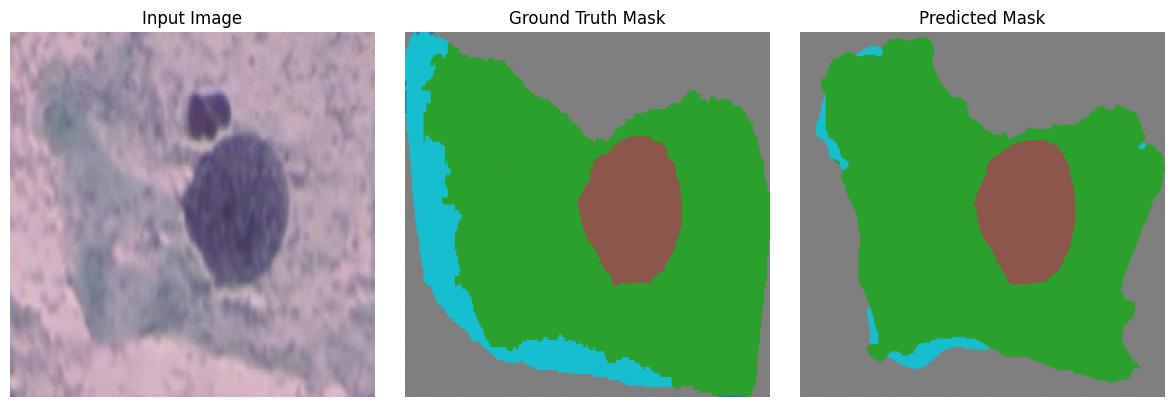


📌 Sample 2
🔢 Ground Truth Unique Values: [0 1 2 3 4]
🔢 Predicted Mask Unique Values: [0 1 2 3 4]

📊 Logits at center pixel (128,128):
Class 0: 1.5307
Class 1: 3.2408
Class 2: -0.1274
Class 3: -3.2515
Class 4: -3.6343
Predicted class: 1
Ground truth class: 1


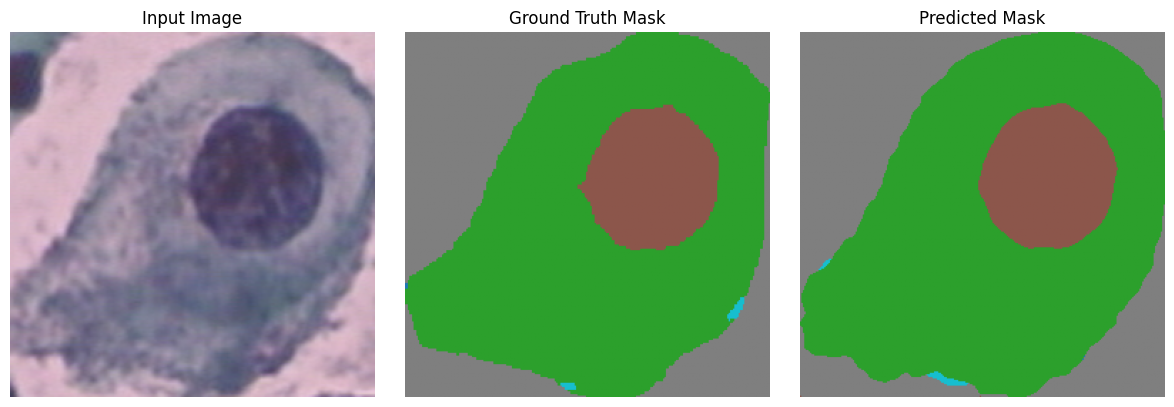


📌 Sample 3
🔢 Ground Truth Unique Values: [0 1 2 3]
🔢 Predicted Mask Unique Values: [0 1 2 3 4]

📊 Logits at center pixel (128,128):
Class 0: -2.5257
Class 1: 2.3492
Class 2: 3.4407
Class 3: -2.6773
Class 4: -5.0080
Predicted class: 2
Ground truth class: 1


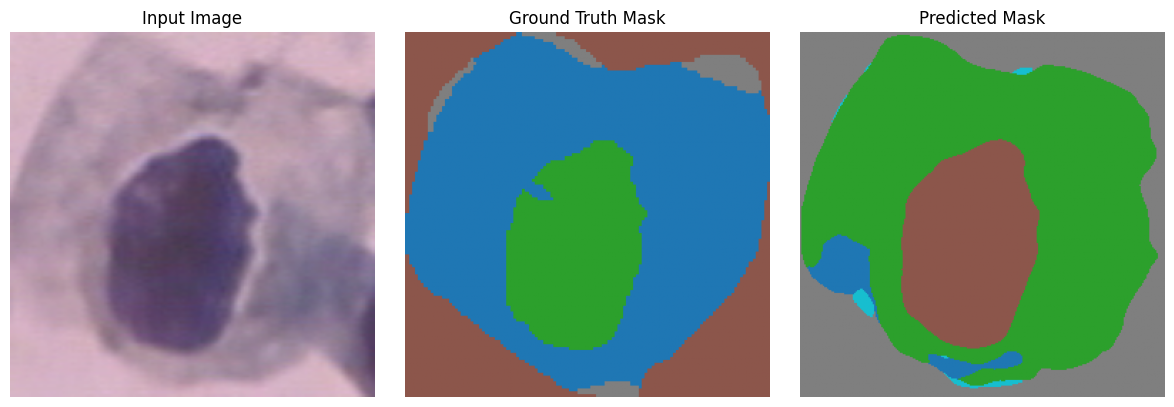


📌 Sample 4
🔢 Ground Truth Unique Values: [0 1 2 3 4]
🔢 Predicted Mask Unique Values: [1 2 3 4]

📊 Logits at center pixel (128,128):
Class 0: 1.5774
Class 1: 2.3958
Class 2: -0.5092
Class 3: -1.9060
Class 4: -2.3178
Predicted class: 1
Ground truth class: 1


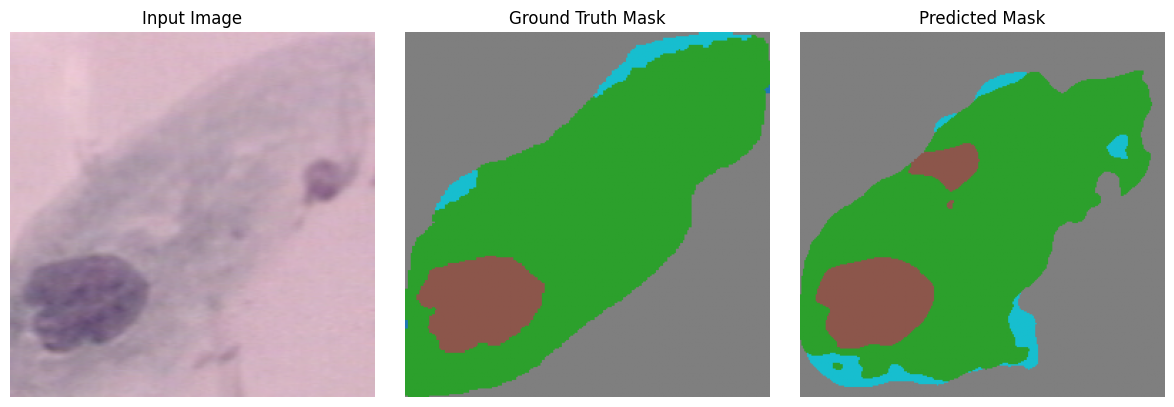


[Raw Logits Shape]: torch.Size([4, 5, 256, 256])  (batch_size, num_classes, H, W)

📌 Sample 5
🔢 Ground Truth Unique Values: [0 1 2 3]
🔢 Predicted Mask Unique Values: [1 2 3 4]

📊 Logits at center pixel (128,128):
Class 0: -2.0814
Class 1: 1.5175
Class 2: 3.3891
Class 3: -2.5341
Class 4: -4.5617
Predicted class: 2
Ground truth class: 2


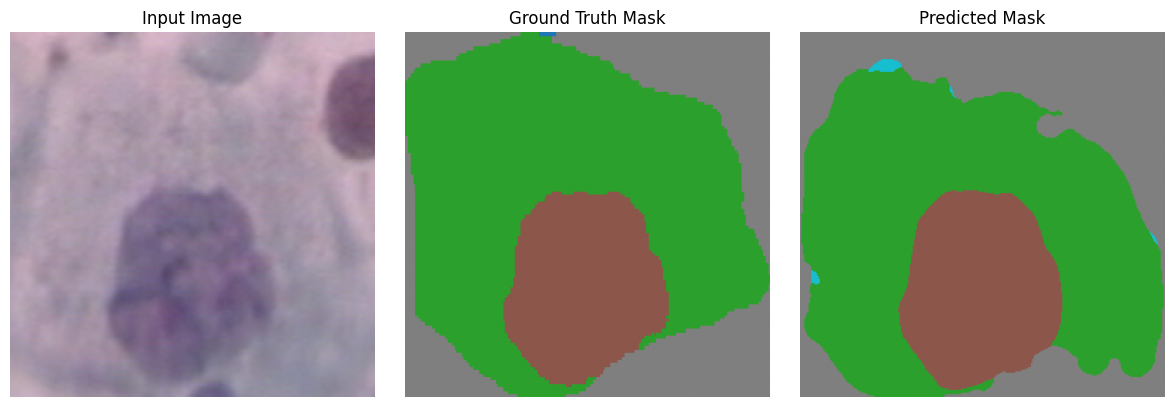


📌 Sample 6
🔢 Ground Truth Unique Values: [0 1 2 3]
🔢 Predicted Mask Unique Values: [1 2 3 4]

📊 Logits at center pixel (128,128):
Class 0: -2.5647
Class 1: 2.5094
Class 2: 3.5300
Class 3: -2.9066
Class 4: -5.1625
Predicted class: 2
Ground truth class: 1


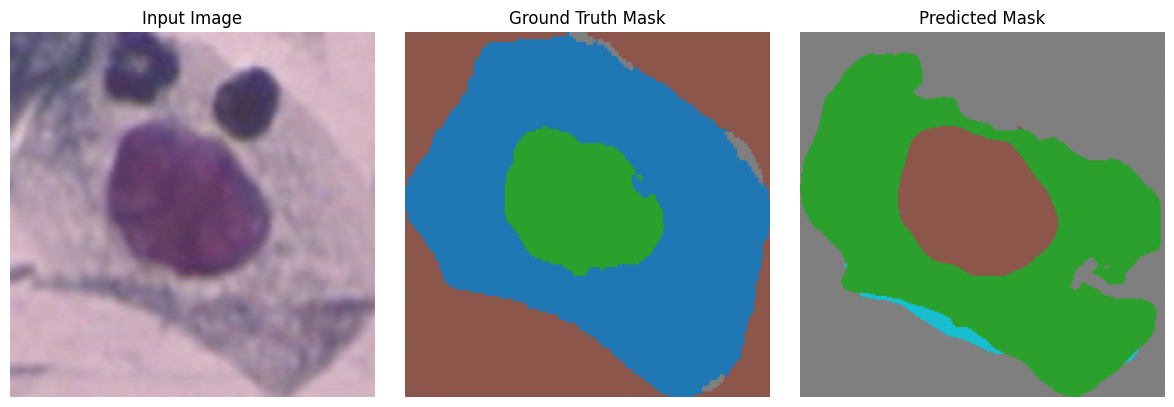


📌 Sample 7
🔢 Ground Truth Unique Values: [0 1 2 3 4]
🔢 Predicted Mask Unique Values: [0 1 2 3 4]

📊 Logits at center pixel (128,128):
Class 0: -2.1755
Class 1: 2.5776
Class 2: 3.0451
Class 3: -2.8837
Class 4: -4.7091
Predicted class: 2
Ground truth class: 2


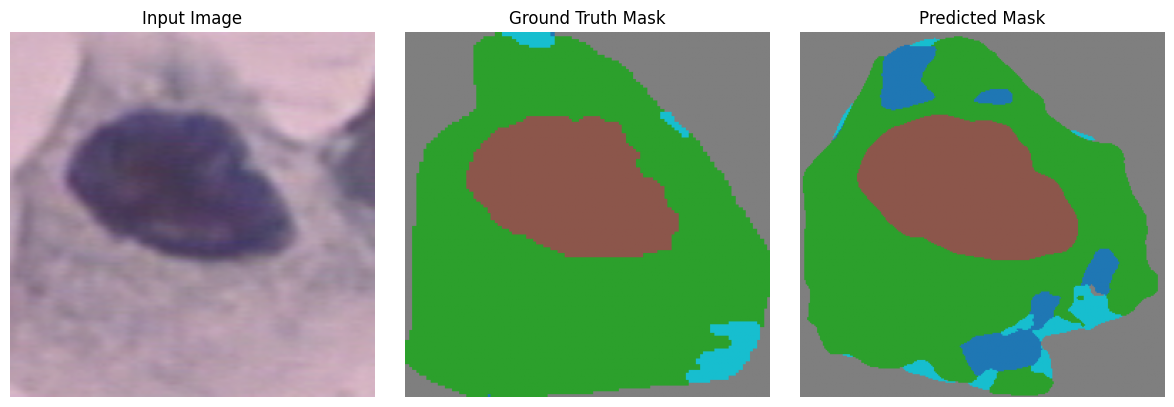


📌 Sample 8
🔢 Ground Truth Unique Values: [0 1 2 3]
🔢 Predicted Mask Unique Values: [0 1 2 3 4]

📊 Logits at center pixel (128,128):
Class 0: -2.5595
Class 1: 2.5032
Class 2: 3.6269
Class 3: -2.9923
Class 4: -5.2968
Predicted class: 2
Ground truth class: 1


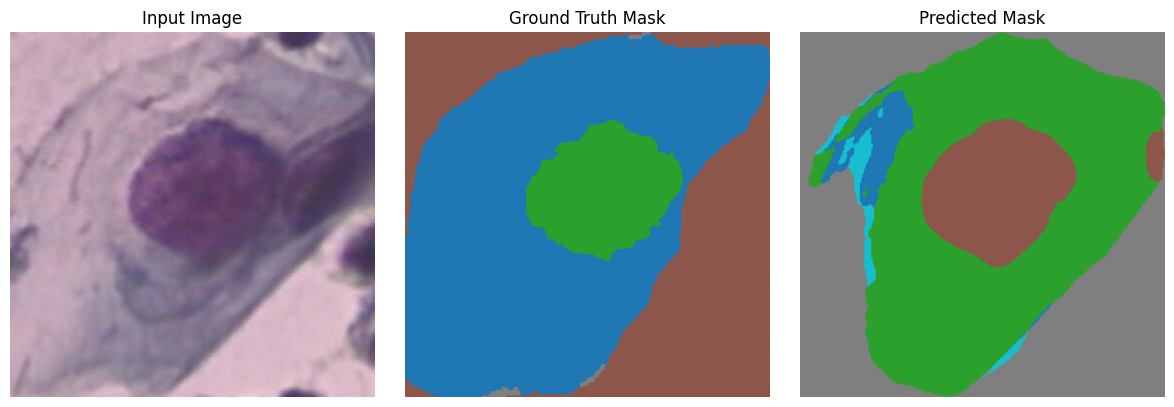


[Raw Logits Shape]: torch.Size([4, 5, 256, 256])  (batch_size, num_classes, H, W)

📌 Sample 9
🔢 Ground Truth Unique Values: [0 1 2 3 4]
🔢 Predicted Mask Unique Values: [0 1 2 3 4]

📊 Logits at center pixel (128,128):
Class 0: -0.3024
Class 1: 1.0517
Class 2: 1.6857
Class 3: -1.7847
Class 4: -2.7246
Predicted class: 2
Ground truth class: 2


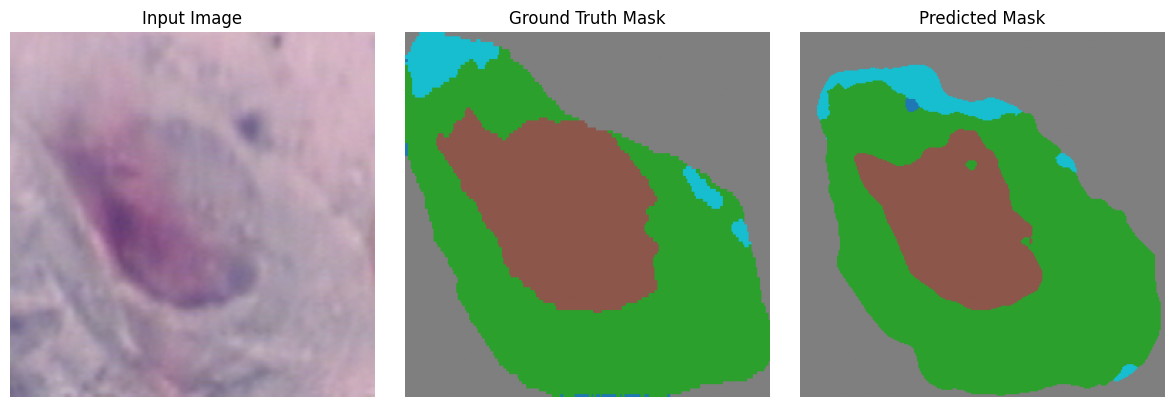


📌 Sample 10
🔢 Ground Truth Unique Values: [0 1 2 3]
🔢 Predicted Mask Unique Values: [1 2 3 4]

📊 Logits at center pixel (128,128):
Class 0: -1.5167
Class 1: 1.4958
Class 2: 2.9754
Class 3: -2.4523
Class 4: -4.2000
Predicted class: 2
Ground truth class: 2


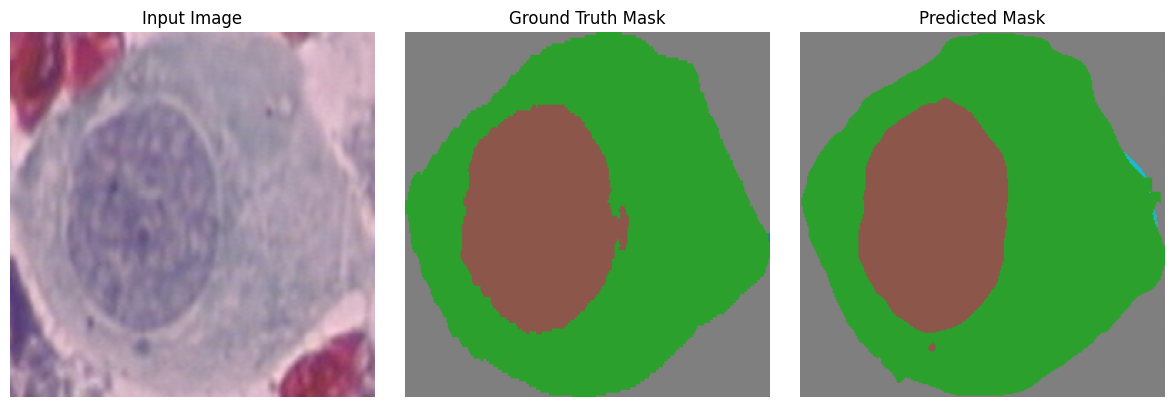

In [24]:
check_mask_values(model, val_loader, device, num_samples=10)

